
# South Korea's Low Fertility Rate: Data-Driven Simulations and Strategic Solutions

1. South Korea's fertility rate and Population Trends
2. Population Projections for 2050
3. Immigrant Numbers Needed for Population Stability
4. Policy Proposals to Increase the fertility rate







### Library and data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import io
import shap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Import the colormap module
!pip install dmba
!pip install shap
!pip install lime
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, \
                            BaggingClassifier, BaggingRegressor, \
                            GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score

from dmba import regressionSummary, exhaustive_search
from sklearn.inspection import PartialDependenceDisplay
!pip install scikit-learn
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
#for plotting decision trees
import pydotplus as pplus
import graphviz
from IPython.display import Image
from six import StringIO
# if not found: ! pip install six
#for modeling with decision trees
from sklearn.tree import export_graphviz
#This function helps with drawing decision trees using the pydotplus and graphviz libraries
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names

    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features,\
                    class_names=classn, filled=filled)
    graph = pplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)

!pip install folium
from urllib.request import urlopen#map
import json
import plotly.express as px
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
world_geo = f'{url}/world-countries.json'

!pip install wbgapi
import wbgapi as wb

from sklearn.linear_model import LinearRegression



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=df461f87b097e6ec785494ebc925117b3145ba53e8dceeac19a254a3477476b9
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
Colab environment detected.


In [12]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Python Course/Large Data Sets for Python/worlddata.csv')

## 1. Fertility Rate and Population Trends in Korea

In [13]:
# Step 1: Filter for Korea data
korea_fertility = df[(df['CountryName'] == 'Korea, Rep.') & (df['IndicatorName'] == 'Fertility rate, total (births per woman)')]
korea_growth = df[(df['CountryName'] == 'Korea, Rep.') & (df['IndicatorName'] == 'Population growth (annual %)')]
korea_population = df[(df['CountryName'] == 'Korea, Rep.') & (df['IndicatorName'] == 'Population, total')]

# change the column name
korea_fertility = korea_fertility[['Year', 'Value']].rename(columns={'Value': 'Fertility Rate'})
korea_growth = korea_growth[['Year', 'Value']].rename(columns={'Value': 'Growth Rate'})
korea_population = korea_population[['Year', 'Value']].rename(columns={'Value': 'Total Population'})

# Step 2: 2013~2024 data from wbgapi
fertility_recent = wb.data.fetch('SP.DYN.TFRT.IN', economy='KOR', time=range(2013, 2025))
fertility_recent = pd.DataFrame(fertility_recent).reset_index()
fertility_recent = fertility_recent[['time', 'value']]
fertility_recent.columns = ['Year', 'Fertility Rate']

fertility_recent['Year'] = fertility_recent['Year'].str.extract('(\d+)').astype(int)

# Step 3: combine the data
combined_fertility = pd.concat([korea_fertility, fertility_recent], ignore_index=True)
combined_fertility = combined_fertility.drop_duplicates(subset='Year').sort_values(by='Year').reset_index(drop=True)

# Step 4: merge data
# Merge fertility and growth rates on 'Year'
merged_data = pd.merge(combined_fertility, korea_growth, on='Year', how='inner', suffixes=('_fertility', '_growth'))

# Merge with population data
merged_data = pd.merge(merged_data, korea_population, on='Year', how='inner')



In [29]:
#= Filter for Korea data
korea_fertility = df[(df['CountryName'] == 'Korea, Rep.') & (df['IndicatorName'] == 'Fertility rate, total (births per woman)')]
korea_growth = df[(df['CountryName'] == 'Korea, Rep.') & (df['IndicatorName'] == 'Population growth (annual %)')]
korea_population = df[(df['CountryName'] == 'Korea, Rep.') & (df['IndicatorName'] == 'Population, total')]

# change the column name
korea_fertility = korea_fertility[['Year', 'Value']].rename(columns={'Value': 'Fertility Rate'})
korea_growth = korea_growth[['Year', 'Value']].rename(columns={'Value': 'Growth Rate'})
korea_population = korea_population[['Year', 'Value']].rename(columns={'Value': 'Total Population'})

fertility_recent = wb.data.fetch('SP.DYN.TFRT.IN', economy='KOR', time=range(2013, 2025))
fertility_recent = pd.DataFrame(fertility_recent).reset_index()
fertility_recent = fertility_recent[['time', 'value']]
fertility_recent.columns = ['Year', 'Fertility Rate']

# drop "YR"
fertility_recent['Year'] = fertility_recent['Year'].str.extract('(\d+)').astype(int)

# Merge Data
combined_fertility = pd.concat([korea_fertility, fertility_recent], ignore_index=True)
combined_fertility = combined_fertility.drop_duplicates(subset='Year').sort_values(by='Year').reset_index(drop=True)

# Merge fertility and growth rates on 'Year'
merged_data = pd.merge(combined_fertility, korea_growth, on='Year', how='inner', suffixes=('_fertility', '_growth'))

# Merge with population data
merged_data = pd.merge(merged_data, korea_population, on='Year', how='inner')

print(merged_data.head())
print(merged_data.tail())


   Year  Fertility Rate  Growth Rate  Total Population
0  1960           6.155     2.907252        25012374.0
1  1961           5.989     2.967244        25765673.0
2  1962           5.789     2.859321        26513030.0
3  1963           5.574     2.784820        27261747.0
4  1964           5.357     2.615395        27984155.0
    Year  Fertility Rate  Growth Rate  Total Population
50  2010           1.226     0.463176        49410366.0
51  2011           1.244     0.744181        49779440.0
52  2012           1.297     0.450977        50004441.0
53  2013           1.187     0.429494        50219669.0
54  2014           1.205     0.405960        50423955.0


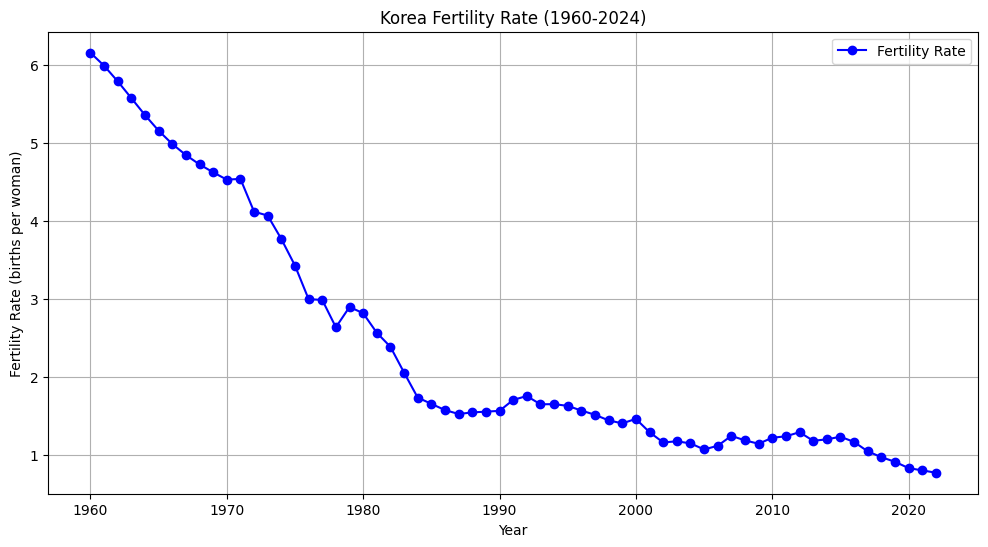

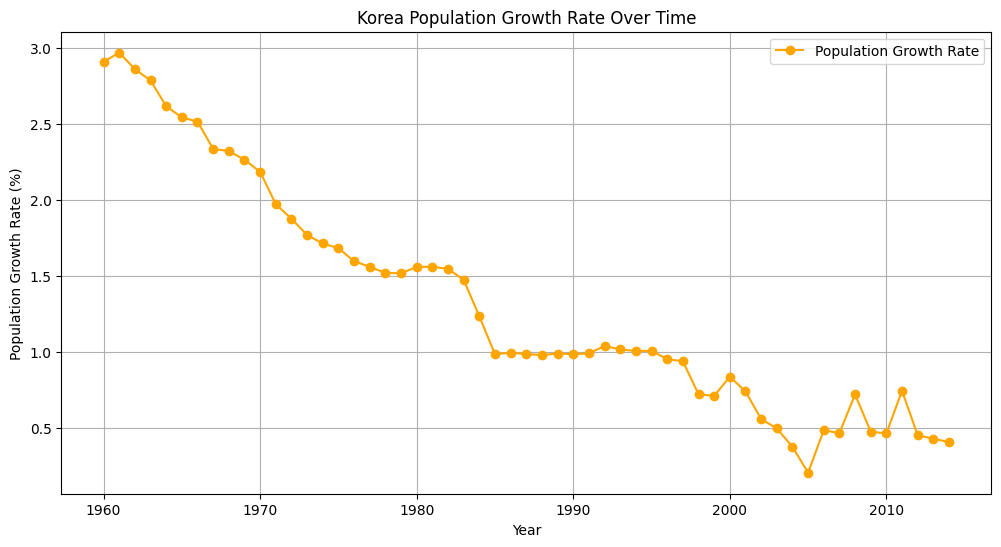

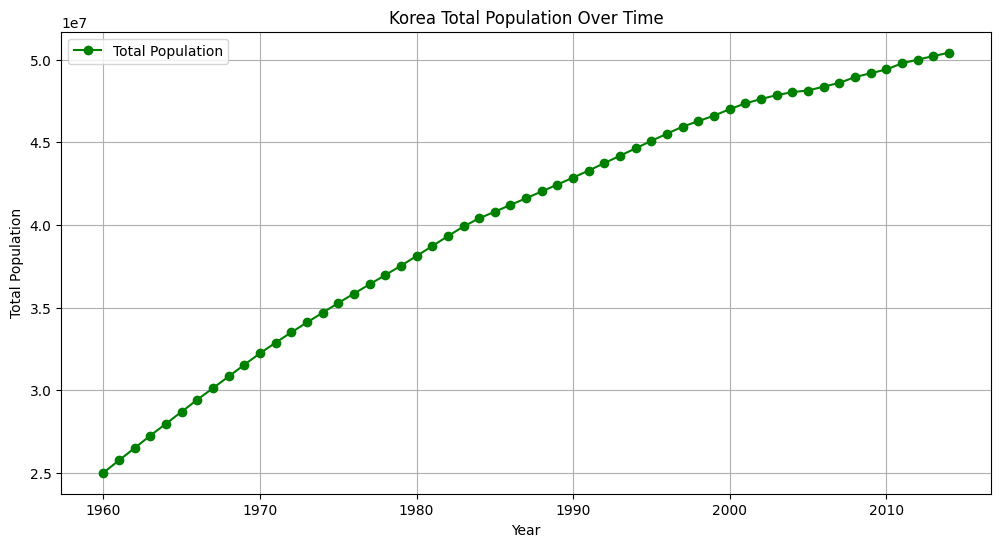

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Line Plot
plt.plot(combined_fertility['Year'], combined_fertility['Fertility Rate'], marker='o', label='Fertility Rate', color='blue')

plt.title('Korea Fertility Rate (1960-2024)')
plt.xlabel('Year')
plt.ylabel('Fertility Rate (births per woman)')
plt.legend()
plt.grid()
plt.show()

import matplotlib.pyplot as plt

# Graph for Population Growth Rate
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Year'], merged_data['Growth Rate'], marker='o', label='Population Growth Rate', color='orange')

# Graph
plt.title('Korea Population Growth Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Population Growth Rate (%)')
plt.legend()
plt.grid()
plt.show()

import matplotlib.pyplot as plt

# Graph for Total Population
plt.figure(figsize=(12, 6))
plt.plot(korea_population['Year'], korea_population['Total Population'], marker='o', label='Total Population', color='green')
plt.title('Korea Total Population Over Time')
plt.xlabel('Year')
plt.ylabel('Total Population')
plt.legend()
plt.grid()
plt.show()



In [16]:
print(combined_fertility.isnull().sum())

Year              0
Fertility Rate    1
dtype: int64


## 2. Population Projections for 2050 in Korea

### 1) Fertility Rate Prediction (1980 - 2050)

In [18]:
combined_fertility.head()

,Year,Fertility Rate
0,1960,6.155
1,1961,5.989
2,1962,5.789
3,1963,5.574
4,1964,5.357


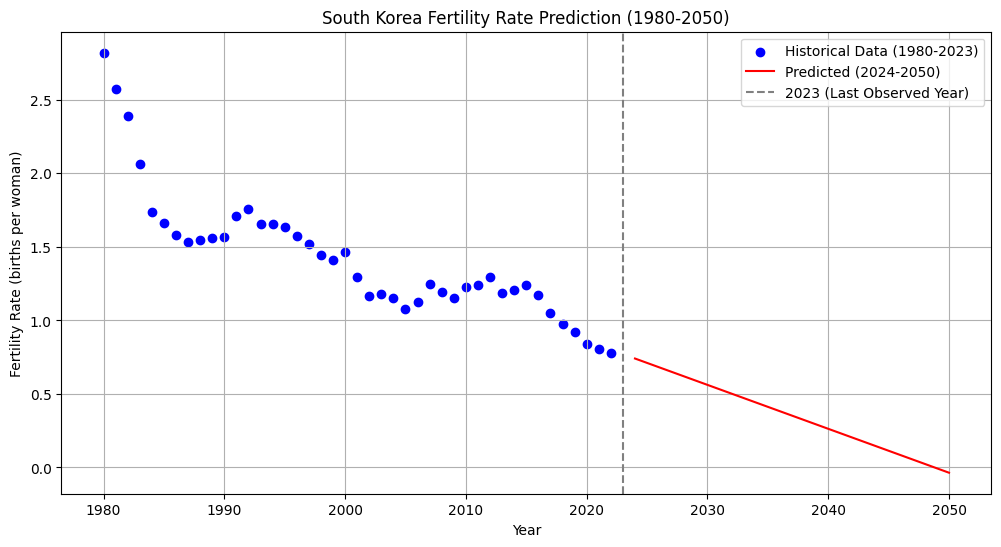

In [70]:

# dataframe
fertility_data = pd.DataFrame(combined_fertility)
fertility_data = fertility_data.reset_index()  # 인덱스 재설정
fertility_data = fertility_data[['Year', 'Fertility Rate']]  # 필요한 열 선택
fertility_data.columns = ['Year', 'Fertility Rate']  # 열 이름 변경

# drop NaN
fertility_data = fertility_data.dropna()

# 1980년 이후 데이터만 필터링
fertility_data = fertility_data[fertility_data['Year'] >= 1980]

# Regression Model
X = fertility_data['Year'].values.reshape(-1, 1)
y = fertility_data['Fertility Rate'].values

model = LinearRegression()
model.fit(X, y)

# Prediction : 2024 - 2050
future_years = np.arange(2024, 2051).reshape(-1, 1)
future_predictions = model.predict(future_years)

# Result visualization
plt.figure(figsize=(12, 6))
plt.scatter(X, y, color='blue', label='Historical Data (1980-2023)')  # 실제 데이터
plt.plot(future_years, future_predictions, color='red', label='Predicted (2024-2050)')  # 예측
plt.xlabel('Year')
plt.ylabel('Fertility Rate (births per woman)')
plt.title('South Korea Fertility Rate Prediction (1980-2050)')
plt.axvline(x=2023, color='gray', linestyle='--', label='2023 (Last Observed Year)')
plt.legend()
plt.grid()
plt.show()


Mean Squared Error: 0.0219
R-Squared: 0.7444


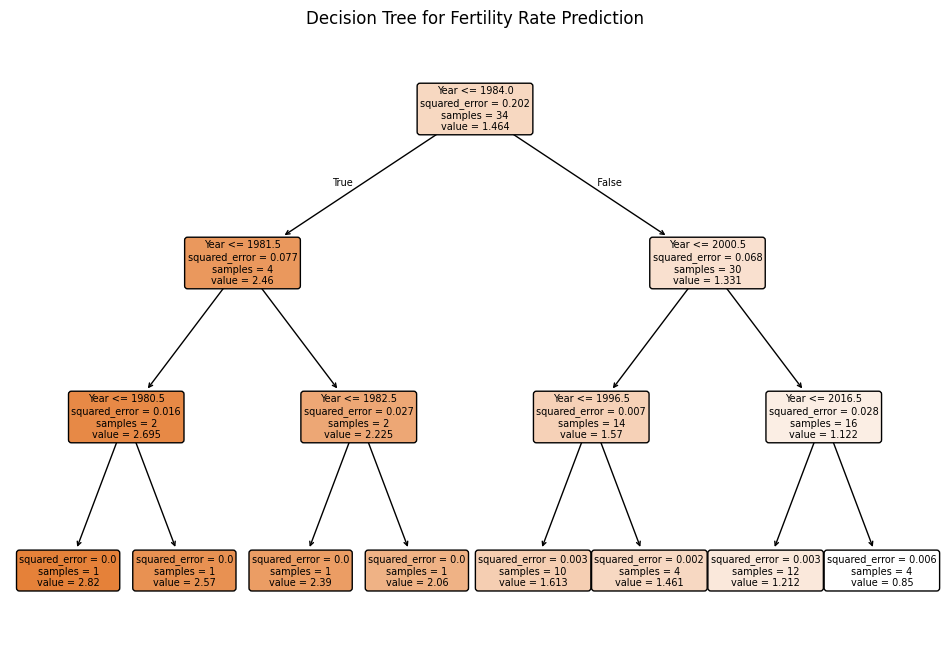

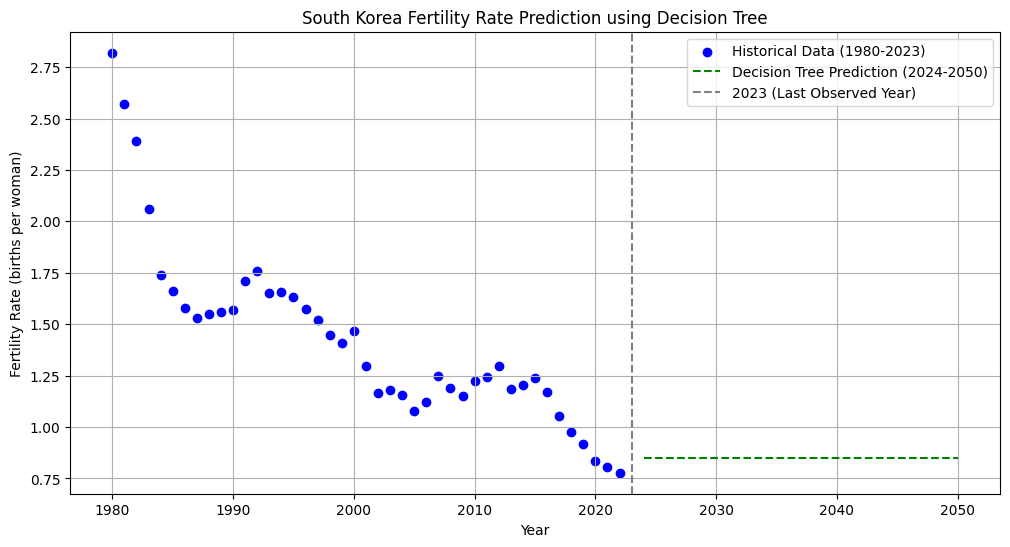

In [72]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Step 1: 데이터 준비
# 기존 데이터프레임 생성
fertility_data = pd.DataFrame(combined_fertility)
fertility_data = fertility_data.reset_index()  # 인덱스 재설정
fertility_data = fertility_data[['Year', 'Fertility Rate']]  # 필요한 열 선택
fertility_data.columns = ['Year', 'Fertility Rate']  # 열 이름 변경

# 결측치 제거
fertility_data = fertility_data.dropna()

# 1980년 이후 데이터 필터링
fertility_data = fertility_data[fertility_data['Year'] >= 1980]

# 독립 변수 (X)와 종속 변수 (y) 설정
X = fertility_data['Year'].values.reshape(-1, 1)  # Feature: Year
y = fertility_data['Fertility Rate'].values       # Target: Fertility Rate

# Step 2: Decision Tree 모델 훈련
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree 모델 생성
tree_model = DecisionTreeRegressor(max_depth=3, random_state=42)  # 트리의 깊이 제한
tree_model.fit(X_train, y_train)  # 학습

# Step 3: 예측 및 평가
y_pred = tree_model.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-Squared: {r2:.4f}")

# Step 4: Decision Tree 시각화
plt.figure(figsize=(12, 8))
plot_tree(tree_model, feature_names=['Year'], filled=True, rounded=True)
plt.title("Decision Tree for Fertility Rate Prediction")
plt.show()

# Step 5: 추가 시각화 (실제 vs 예측 결과)
# Decision Tree를 통해 예측된 값 시각화
future_years = np.arange(2024, 2051).reshape(-1, 1)
future_predictions = tree_model.predict(future_years)

plt.figure(figsize=(12, 6))
plt.scatter(X, y, color='blue', label='Historical Data (1980-2023)')
plt.plot(future_years, future_predictions, color='green', linestyle='--', label='Decision Tree Prediction (2024-2050)')
plt.xlabel('Year')
plt.ylabel('Fertility Rate (births per woman)')
plt.title('South Korea Fertility Rate Prediction using Decision Tree')
plt.axvline(x=2023, color='gray', linestyle='--', label='2023 (Last Observed Year)')
plt.legend()
plt.grid()
plt.show()


### 2) Total Population Projections of Korea

In [23]:
# Since data from 2015 to 2022 is important and not available in the world dataset, I used data from the wbgapi instead.

# Step 1: Fetch data for Birth Rate, Death Rate, and Net Migration Rate
# Indicator Codes: SP.DYN.CBRT.IN (Birth Rate), SP.DYN.CDRT.IN (Death Rate), SM.POP.NETM (Net Migration)
birth_rate_data = wb.data.fetch('SP.DYN.CBRT.IN', economy='KOR', time=2022)
death_rate_data = wb.data.fetch('SP.DYN.CDRT.IN', economy='KOR', time=2022)
net_migration_data = wb.data.fetch('SM.POP.NETM', economy='KOR', time=2022)

# Step 2: Convert fetched data to DataFrames
birth_rate_df = pd.DataFrame(birth_rate_data).reset_index()
death_rate_df = pd.DataFrame(death_rate_data).reset_index()
net_migration_df = pd.DataFrame(net_migration_data).reset_index()

# Step 3: Extract relevant values and rename columns
birth_rate_df = birth_rate_df[['time', 'value']].rename(columns={'value': 'Birth Rate (%)'})
death_rate_df = death_rate_df[['time', 'value']].rename(columns={'value': 'Death Rate (%)'})
net_migration_df = net_migration_df[['time', 'value']].rename(columns={'value': 'Net Migration Rate (%)'})

# Step 4: Merge all data into a single DataFrame for the year 2024
growth_rate_data = birth_rate_df.merge(death_rate_df, on='time').merge(net_migration_df, on='time')
growth_rate_data.rename(columns={'time': 'Year'}, inplace=True)

# Step 5: Calculate Growth Rate
growth_rate_data['Growth Rate (%)'] = (
    growth_rate_data['Birth Rate (%)'] - growth_rate_data['Death Rate (%)'] +
    growth_rate_data['Net Migration Rate (%)']
)

# Display the final DataFrame
print(growth_rate_data)


     Year  Birth Rate (%)  Death Rate (%)  Net Migration Rate (%)  \
0  YR2022             4.9             7.3                   29998   

   Growth Rate (%)  
0          29995.6  


In [24]:
# Total Population - data check
total_population_data = wb.data.fetch('SP.POP.TOTL', economy='KOR', time=2022)
total_population_df = pd.DataFrame(total_population_data).reset_index()
total_population_df = total_population_df[['time', 'value']].rename(columns={'value': 'Total Population'})

# Collect and compare net migration data
net_migration_df = net_migration_df.merge(total_population_df, on='time')
net_migration_df['Net Migration Rate (%)'] = (
    net_migration_df['Net Migration Rate (%)'] / net_migration_df['Total Population'] * 100
)

# Merge migration rate, birth rate, and death rate data
growth_rate_data = birth_rate_df.merge(death_rate_df, on='time').merge(net_migration_df, on='time')
growth_rate_data.rename(columns={'time': 'Year'}, inplace=True)

# Growth rate calculation
growth_rate_data['Growth Rate (%)'] = (
    growth_rate_data['Birth Rate (%)'] - growth_rate_data['Death Rate (%)'] +
    growth_rate_data['Net Migration Rate (%)']
)

# print result
print(growth_rate_data)


     Year  Birth Rate (%)  Death Rate (%)  Net Migration Rate (%)  \
0  YR2022             4.9             7.3                0.058054   

   Total Population  Growth Rate (%)  
0          51672569        -2.341946  


In [27]:
# Fix the fertliity rate (2022)
fixed_fertility_rate = 0.8  # Make assumption it will continue to 2050.

# Check the latest population
latest_population = merged_data['Total Population'].iloc[-1]

# Growth rate
fixed_growth_rate = -2.34  #caculated from upper cell

# Calculation for future population
future_years = range(2023, 2051)
future_population = []
current_population = latest_population

for year in future_years:
    # growth rate
    current_population *= (1 + fixed_growth_rate / 100)
    future_population.append({'Year': year, 'Total Population': current_population})

future_population_df = pd.DataFrame(future_population)

print(future_population_df)


    Year  Total Population
0   2023      4.924403e+07
1   2024      4.809172e+07
2   2025      4.696638e+07
3   2026      4.586736e+07
4   2027      4.479407e+07
5   2028      4.374589e+07
6   2029      4.272223e+07
7   2030      4.172253e+07
8   2031      4.074623e+07
9   2032      3.979276e+07
10  2033      3.886161e+07
11  2034      3.795225e+07
12  2035      3.706417e+07
13  2036      3.619687e+07
14  2037      3.534986e+07
15  2038      3.452267e+07
16  2039      3.371484e+07
17  2040      3.292592e+07
18  2041      3.215545e+07
19  2042      3.140301e+07
20  2043      3.066818e+07
21  2044      2.995055e+07
22  2045      2.924970e+07
23  2046      2.856526e+07
24  2047      2.789683e+07
25  2048      2.724405e+07
26  2049      2.660654e+07
27  2050      2.598394e+07


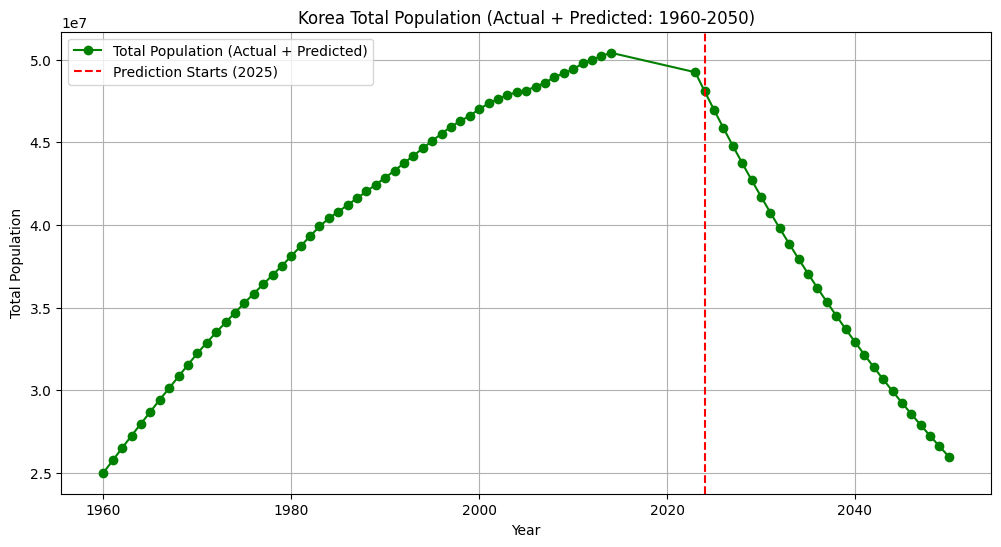

In [28]:
combined_population = pd.concat([
    merged_data[['Year', 'Total Population']],
    future_population_df
]).reset_index(drop=True)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(combined_population['Year'], combined_population['Total Population'], marker='o', label='Total Population (Actual + Predicted)', color='green')
plt.axvline(x=2024, linestyle='--', color='red', label='Prediction Starts (2025)')
plt.title('Korea Total Population (Actual + Predicted: 1960-2050)')
plt.xlabel('Year')
plt.ylabel('Total Population')
plt.legend()
plt.grid()
plt.show()


## 3. Number of immigrants to maintain the current population

In [30]:
# Convert the generator to a list
total_population_list = list(total_population_data)

# Inspect the first few elements of the list
print(total_population_list)


[]


In [31]:
from sklearn.linear_model import LinearRegression

# Filter for fertility rate data
fertility_data = df[(df['CountryName'] == 'Korea, Rep.') & (df['IndicatorName'] == 'Fertility rate, total (births per woman)')]

# Filter for population growth data
population_growth = df[(df['CountryName'] == 'Korea, Rep.') & (df['IndicatorName'] == 'Population growth (annual %)')]

# Merge fertility and population growth data
fertility_growth_data = pd.merge(fertility_data, population_growth, on=['CountryName', 'Year'], suffixes=('_fertility', '_growth'))

# Display the first few rows of the merged data for confirmation
print(fertility_growth_data.head())


   CountryName CountryCode_fertility  \
0  Korea, Rep.                   KOR   
1  Korea, Rep.                   KOR   
2  Korea, Rep.                   KOR   
3  Korea, Rep.                   KOR   
4  Korea, Rep.                   KOR   

                    IndicatorName_fertility IndicatorCode_fertility  Year  \
0  Fertility rate, total (births per woman)          SP.DYN.TFRT.IN  1960   
1  Fertility rate, total (births per woman)          SP.DYN.TFRT.IN  1961   
2  Fertility rate, total (births per woman)          SP.DYN.TFRT.IN  1962   
3  Fertility rate, total (births per woman)          SP.DYN.TFRT.IN  1963   
4  Fertility rate, total (births per woman)          SP.DYN.TFRT.IN  1964   

   Value_fertility CountryCode_growth          IndicatorName_growth  \
0            6.155                KOR  Population growth (annual %)   
1            5.989                KOR  Population growth (annual %)   
2            5.789                KOR  Population growth (annual %)   
3           

In [32]:
# Replacement fertility rate
replacement_rate = 2.1 # Replacement fertility rate (births per woman)

# Prepare the merged data for simulation
fertility_growth_data = fertility_growth_data[['Year', 'Value_fertility', 'Value_growth']]  # Select relevant columns

# Add a column to calculate fertility rate gap
fertility_growth_data['Fertility Gap'] = replacement_rate - fertility_growth_data['Value_fertility']
fertility_growth_data['Fertility Gap'] = fertility_growth_data['Fertility Gap'].apply(lambda x: max(0, x))  # No negative gaps

# Estimate the population growth decline due to the fertility gap
fertility_growth_data['Population Decline Rate'] = fertility_growth_data['Fertility Gap'] / replacement_rate


<ipython-input-32-b84ae09df5e1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fertility_growth_data['Fertility Gap'] = replacement_rate - fertility_growth_data['Value_fertility']
<ipython-input-32-b84ae09df5e1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fertility_growth_data['Fertility Gap'] = fertility_growth_data['Fertility Gap'].apply(lambda x: max(0, x))  # No negative gaps
<ipython-input-32-b84ae09df5e1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [43]:
total_population = 50_000_000
# Calculate the required number of immigrants to maintain the population
fertility_growth_data['Required Immigrants'] = fertility_growth_data['Population Decline Rate'] * total_population



In [44]:
# Select only numeric columns for correlation analysis
numeric_growth_data = fertility_growth_data.select_dtypes(include=['float64', 'int64'])

# Calculate correlation coefficients
correlation_growth = numeric_growth_data.corr()

# Display correlation coefficients for fertility rate
print("Correlation between Fertility Rate and Population Growth:")
print(correlation_growth['Value_fertility'])


Correlation between Fertility Rate and Population Growth:
Year                      -0.919910
Value_fertility            1.000000
Value_growth               0.975934
Fertility Gap             -0.816521
Population Decline Rate   -0.816521
Required Immigrants       -0.816521
Name: Value_fertility, dtype: float64


성장률 예측

In [66]:
# 테스트 데이터와 예측값의 결측값 확인
print(f"Number of NaN in y_test: {np.isnan(y_test).sum()}")
print(f"Number of NaN in y_pred: {np.isnan(y_pred).sum()}")

# 테스트 데이터 확인
print(y_test.head())
print(y_pred[:5])  # 예측값의 일부 확인
fertility_growth_data = fertility_growth_data[fertility_growth_data['Year'] >= 1980]


Number of NaN in y_test: 0
Number of NaN in y_pred: 0
31    43295704.0
5     28704674.0
32    43747962.0
13    34103149.0
19    37534236.0
Name: Population, total, dtype: float64
[42748731.42088521 29144928.05251408 42753826.80374032 33021626.03332203
 36897297.07448256]


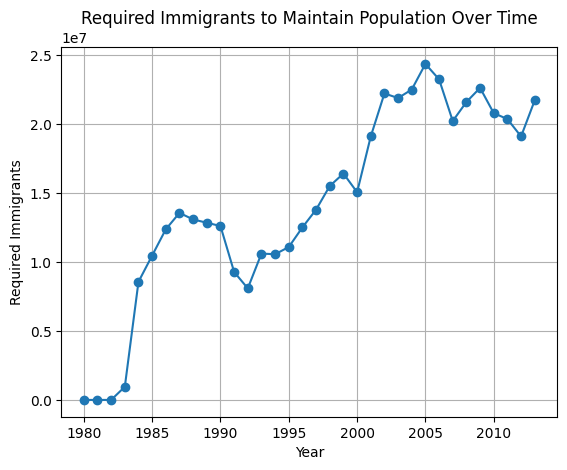

In [67]:
# Plot the required number of immigrants over time
plt.plot(fertility_growth_data['Year'], fertility_growth_data['Required Immigrants'], marker='o')
plt.title('Required Immigrants to Maintain Population Over Time')
plt.xlabel('Year')
plt.ylabel('Required Immigrants')
plt.grid()
plt.show()


## 4. Policy Proposals to Increase the fertility rate and population

Filtered Data:
       CountryName CountryCode                             IndicatorName  \
13348  Korea, Rep.         KOR      Death rate, crude (per 1,000 people)   
13362  Korea, Rep.         KOR  Fertility rate, total (births per woman)   
13502  Korea, Rep.         KOR                         Population, total   
13515  Korea, Rep.         KOR                          Urban population   
38534  Korea, Rep.         KOR      Death rate, crude (per 1,000 people)   

        IndicatorCode  Year         Value  
13348  SP.DYN.CDRT.IN  1960  1.434400e+01  
13362  SP.DYN.TFRT.IN  1960  6.155000e+00  
13502     SP.POP.TOTL  1960  2.501237e+07  
13515     SP.URB.TOTL  1960  6.930929e+06  
38534  SP.DYN.CDRT.IN  1961  1.382400e+01  
Pivoted Data:
IndicatorName  Year  Death rate, crude (per 1,000 people)  \
0              1960                                14.344   
1              1961                                13.824   
2              1962                                13.261   
3     

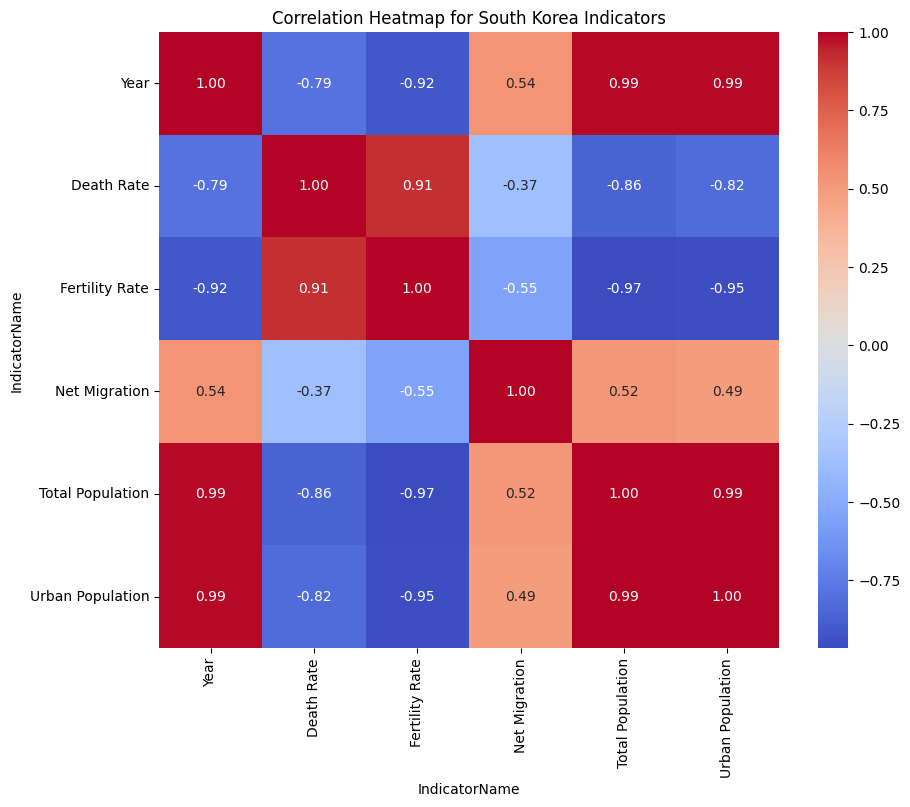

In [74]:
# Define the relevant indicators
relevant_indicators = [
    'Fertility rate, total (births per woman)',
    'Death rate, crude (per 1,000 people)',
    'Urban population',
    'Population ages 65 and above, total',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)',
    'Net migration',
    'Population, total'
]

# Filter the dataset for South Korea and the relevant indicators
korea_data = df[
    (df['CountryName'] == 'Korea, Rep.') &
    (df['IndicatorName'].isin(relevant_indicators))
]

# Display the filtered data
print("Filtered Data:")
print(korea_data.head())

# Pivot the table to make IndicatorName the columns
korea_data_pivoted = korea_data.pivot_table(
    index='Year',
    columns='IndicatorName',
    values='Value'
).reset_index()

# Display the reshaped data
print("Pivoted Data:")
print(korea_data_pivoted.head())

# Rename columns for clarity
korea_data_pivoted.rename(columns={
    'Fertility rate, total (births per woman)': 'Fertility Rate',
    'Death rate, crude (per 1,000 people)': 'Death Rate',
    'Urban population': 'Urban Population',
    'Population ages 65 and above, total': 'Population Age 65+',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)': 'Unemployment Rate',
    'Net migration': 'Net Migration',
    'Population, total': 'Total Population'
}, inplace=True)

# Drop rows with missing values (optional)
korea_data_pivoted.dropna(inplace=True)

# Display the cleaned data
print("Cleaned Data:")
print(korea_data_pivoted.head())

# Calculate the correlation matrix
correlation_matrix = korea_data_pivoted.corr()

# Display correlations with Total Population
print("Correlations with Total Population:")
print(correlation_matrix['Total Population'].sort_values(ascending=False))

# Visualize the correlation matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap for South Korea Indicators")
plt.show()




## 4. Variables affecing population

In [45]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Selected indicators
selected_indicators = [
    "Fertility rate, total (births per woman)",
    "Net migration (number)",
    "Life expectancy at birth, total (years)",
    "GDP per capita (current US$)",
    "Unemployment, total (% of total labor force)",
    "Urban population (% of total population)",
    "CO2 emissions (metric tons per capita)",
    "Health expenditure per capita (current US$)"
]

# Filter data for selected indicators
filtered_data = df[df['IndicatorName'].isin(selected_indicators) | (df['IndicatorName'] == 'Population, total')]

# Pivot data to have years as rows and indicators as columns
pivot_data = filtered_data.pivot_table(values='Value', index=['CountryName', 'Year'], columns='IndicatorName')

# Reset index for easier handling
pivot_data.reset_index(inplace=True)

# Filter for Korea
korea_data = pivot_data[pivot_data['CountryName'] == 'Korea, Rep.']

# Drop non-numeric columns and handle missing values
korea_data_numeric = korea_data.drop(columns=['CountryName', 'Year'], errors='ignore')
imputer = SimpleImputer(strategy="mean")
korea_data_imputed = pd.DataFrame(imputer.fit_transform(korea_data_numeric), columns=korea_data_numeric.columns)

# Separate features (X) and target variable (y)
X = korea_data_imputed.drop(columns=['Population, total'])
y = korea_data_imputed['Population, total']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display results
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Display feature importance
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Mean Squared Error: 471356447917.18317
R-squared: 0.9898835391294829

Feature Importance:
                                        Feature   Coefficient
2                  GDP per capita (current US$)  3.492066e+06
4       Life expectancy at birth, total (years)  1.229666e+06
5  Unemployment, total (% of total labor force)  1.740171e+05
3   Health expenditure per capita (current US$) -8.019028e+05
0        CO2 emissions (metric tons per capita) -1.048492e+06
1      Fertility rate, total (births per woman) -4.532039e+06


/usr/local/lib/python3.10/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


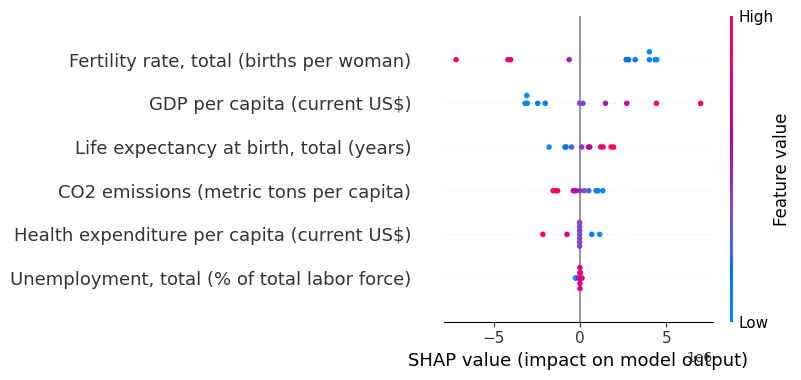

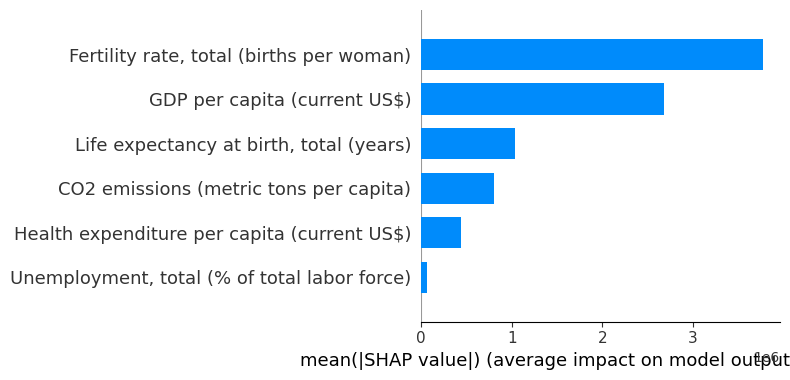

In [46]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP explainer with the trained model and scaled features
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Convert SHAP values to a DataFrame for better readability
shap_df = pd.DataFrame(shap_values, columns=X.columns)

# Display summary plot for SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Display feature importance as a bar plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")


Mean Squared Error (Fertility Rate): 0.06012861243667503
R-squared (Fertility Rate): 0.9679549026248836

Feature Importance for Fertility Rate:
                                        Feature  Coefficient
1                  GDP per capita (current US$)     1.004568
5  Unemployment, total (% of total labor force)     0.071591
0        CO2 emissions (metric tons per capita)    -0.146286
2   Health expenditure per capita (current US$)    -0.150403
3       Life expectancy at birth, total (years)    -0.304695
4                             Population, total    -1.911884


/usr/local/lib/python3.10/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


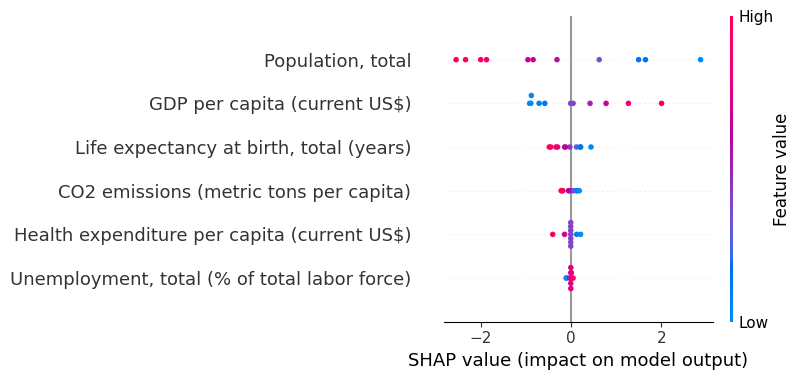

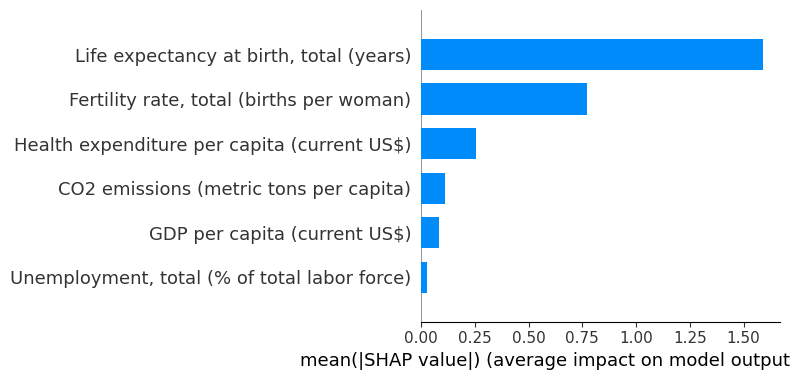

In [53]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

# Separate features (X) and target variable (y)
X_fertility = korea_data_imputed.drop(columns=['Fertility rate, total (births per woman)'])
y_fertility = korea_data_imputed['Fertility rate, total (births per woman)']

# Standardize the features
scaler_fertility = StandardScaler()
X_fertility_scaled = scaler_fertility.fit_transform(X_fertility)

# Split data into training and testing sets
X_train_fertility, X_test_fertility, y_train_fertility, y_test_fertility = train_test_split(
    X_fertility_scaled, y_fertility, test_size=0.2, random_state=42
)

# Train a linear regression model
model_fertility = LinearRegression()
model_fertility.fit(X_train_fertility, y_train_fertility)

# Make predictions
y_pred_fertility = model_fertility.predict(X_test_fertility)

# Evaluate the model
mse_fertility = mean_squared_error(y_test_fertility, y_pred_fertility)
r2_fertility = r2_score(y_test_fertility, y_pred_fertility)

# Display results
print(f"Mean Squared Error (Fertility Rate): {mse_fertility}")
print(f"R-squared (Fertility Rate): {r2_fertility}")

# Display feature importance
feature_importance_fertility = pd.DataFrame({
    "Feature": X_fertility.columns,
    "Coefficient": model_fertility.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance for Fertility Rate:")
print(feature_importance_fertility)

# SHAP Analysis
explainer = shap.LinearExplainer(model_fertility, X_train_fertility, feature_perturbation="interventional")
shap_values = explainer(X_test_fertility)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_fertility, feature_names=X_fertility.columns)
shap.summary_plot(shap_values, X_test_fertility, feature_names=X.columns, plot_type="bar")



Mean Squared Error (Fertility Rate): 0.06012861243667503
R-squared (Fertility Rate): 0.9679549026248836

Feature Importance for Fertility Rate:
                                        Feature  Coefficient
1                  GDP per capita (current US$)     1.004568
5  Unemployment, total (% of total labor force)     0.071591
0        CO2 emissions (metric tons per capita)    -0.146286
2   Health expenditure per capita (current US$)    -0.150403
3       Life expectancy at birth, total (years)    -0.304695
4                             Population, total    -1.911884


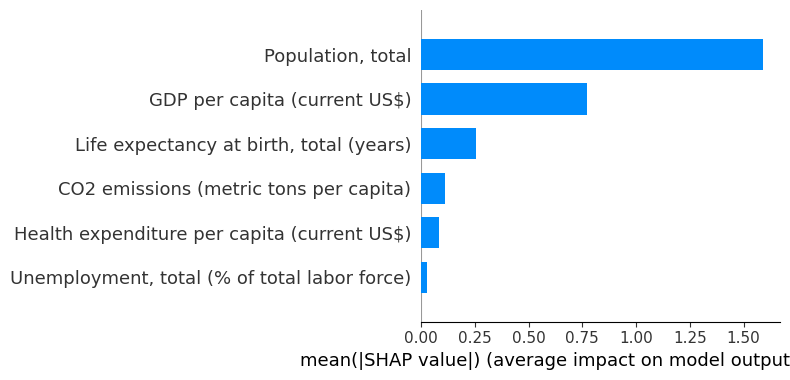


Top 10 Selected Features:
['Population, total' 'GDP per capita (current US$)'
 'Life expectancy at birth, total (years)'
 'CO2 emissions (metric tons per capita)'
 'Health expenditure per capita (current US$)'
 'Unemployment, total (% of total labor force)']


In [65]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

# Separate features (X) and target variable (y)
X_fertility = korea_data_imputed.drop(columns=['Fertility rate, total (births per woman)'])
y_fertility = korea_data_imputed['Fertility rate, total (births per woman)']

# Standardize the features
scaler_fertility = StandardScaler()
X_fertility_scaled = scaler_fertility.fit_transform(X_fertility)

# Split data into training and testing sets
X_train_fertility, X_test_fertility, y_train_fertility, y_test_fertility = train_test_split(
    X_fertility_scaled, y_fertility, test_size=0.2, random_state=42
)

# Train a linear regression model
model_fertility = LinearRegression()
model_fertility.fit(X_train_fertility, y_train_fertility)

# Make predictions
y_pred_fertility = model_fertility.predict(X_test_fertility)

# Evaluate the model
mse_fertility = mean_squared_error(y_test_fertility, y_pred_fertility)
r2_fertility = r2_score(y_test_fertility, y_pred_fertility)

# Display results
print(f"Mean Squared Error (Fertility Rate): {mse_fertility}")
print(f"R-squared (Fertility Rate): {r2_fertility}")

# Display feature importance
feature_importance_fertility = pd.DataFrame({
    "Feature": X_fertility.columns,
    "Coefficient": model_fertility.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance for Fertility Rate:")
print(feature_importance_fertility)

# SHAP Analysis
explainer = shap.LinearExplainer(model_fertility, X_train_fertility)
shap_values = explainer(X_test_fertility)

# SHAP Bar Plot for Top Features
shap_values_mean = pd.DataFrame({
    "Feature": X_fertility.columns,
    "Mean SHAP Value": abs(shap_values.values).mean(axis=0)
}).sort_values(by="Mean SHAP Value", ascending=False)

# Select top 10 features
top_features = shap_values_mean["Feature"].head(10).values

# SHAP Summary Bar Plot
# SHAP Summary Bar Plot (Top 10 Features)
shap.summary_plot(shap_values, X_test_fertility, feature_names=X_fertility.columns, plot_type="bar", max_display=10)


print("\nTop 10 Selected Features:")
print(top_features)
